<a href="https://colab.research.google.com/github/MohmedAAK/Multi-filter-layer/blob/main/code/fixed%20structure%20percentage%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 21.4 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model,load_model
#from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Concatenate
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform

def Conv2D_M_filters_id(X_1,F,conv_name_base,pad,strid,mm1,mm2,mm3):
    f1=int(F*mm1)
    f2=int(F*mm2)
    f3=int(F*mm3)
    remain=F-(f1+f2+f3)
    f1+=remain
    X1=None
    X2=None
    if pad=='same':
            if f3!=0:
                X1= Conv2D(filters=f3, kernel_size=(7, 7), strides=strid, padding='same', name=conv_name_base +"2b2-7x7", kernel_initializer=glorot_uniform(seed=0))(X_1)
            if f2!=0:
                X2= Conv2D(filters=f2, kernel_size=(5, 5), strides=strid, padding='same', name=conv_name_base + '2b3-5x5', kernel_initializer=glorot_uniform(seed=0))(X_1)
            X3= Conv2D(filters=f1, kernel_size=(3, 3), strides=strid, padding='same', name=conv_name_base+"-3x3" , kernel_initializer=glorot_uniform(seed=0))(X_1)
    else:
        if strid==(1,1):
            if f3!=0:
                X1= Conv2D(filters=f3, kernel_size=(7, 7), strides=strid, padding='valid', name=conv_name_base + '2b2-7x7', kernel_initializer=glorot_uniform(seed=0))(X_1)
                X1=ZeroPadding2D(padding=2)(X1)
            if f2!=0:
                X2= Conv2D(filters=f2, kernel_size=(5, 5), strides=strid, padding='valid', name=conv_name_base + '2b3-5x5', kernel_initializer=glorot_uniform(seed=0))(X_1)
                X2=ZeroPadding2D(padding=1)(X2)
            X3= Conv2D(filters=f1, kernel_size=(3, 3), strides=strid, padding='valid', name=conv_name_base+"-3x3" , kernel_initializer=glorot_uniform(seed=0))(X_1)
        else:
            if f3!=0:
                X1= Conv2D(filters=f3, kernel_size=(7, 7), strides=strid, padding='valid', name=conv_name_base + '2b2-7x7', kernel_initializer=glorot_uniform(seed=0))(X_1)
                X1=ZeroPadding2D(padding=1)(X1)
            if f2!=0:
                X2= Conv2D(filters=f2, kernel_size=(5, 5), strides=strid, padding='valid', name=conv_name_base + '2b3-5x5', kernel_initializer=glorot_uniform(seed=0))(X_1)
                X2=ZeroPadding2D(padding=((0, 1), (0, 1)))(X2)#((top_pad, bottom_pad), (left_pad, right_pad))
            X3= Conv2D(filters=f1, kernel_size=(3, 3), strides=strid, padding='valid', name=conv_name_base+"-3x3" , kernel_initializer=glorot_uniform(seed=0))(X_1)

    if f3!=0:
        X=Concatenate(axis=-1)([X1,X2,X3])
    elif f2!=0:
        X=Concatenate(axis=-1)([X2,X3])
    else:
        X=X3
    return X
def insert_layer_nonseq(model, mm1,mm2,mm3,position='replace'):
    filter_name={}
    padding={}
    names=[]
    strid_={}
    for i in model.layers:
        layer_type = type(i).__name__
        if layer_type== 'Conv2D' and i.kernel_size == (3,3):
            filter_name[i.name]=i.filters
            padding[i.name]=i.padding
            names.append(i.name)
            strid_[i.name]=i.strides
      # Auxiliary dictionary to describe the network graph
        network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

    # Set the input layers of each layer
    for layer in model.layers:
        for node in layer._outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer_name not in network_dict['input_layers_of']:
                network_dict['input_layers_of'].update(
                        {layer_name: [layer.name]})
            else:
                network_dict['input_layers_of'][layer_name].append(layer.name)

    # Set the output tensor of the input layer
    network_dict['new_output_tensor_of'].update(
            {model.layers[0].name: model.input})

    # Iterate over all layers after the input
    x = None
    for layer in model.layers[1:]:

        # Determine input tensors
        layer_input = [network_dict['new_output_tensor_of'][layer_aux]
                for layer_aux in network_dict['input_layers_of'][layer.name]]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        # Insert layer if name matches the regular expression
        if  layer.name in names :
            if position == 'replace':
                x = layer_input
            elif position == 'after':
                x = layer(layer_input)
            elif position == 'before':
                pass
            else:
                raise ValueError('position must be: before, after or replace')
            print(layer.filters,layer.strides,layer.padding,layer.kernel_size)
            new_layer = Conv2D_M_filters_id(x,filter_name[layer.name],layer.name,pad=padding[layer.name],strid=strid_[layer.name],mm1=mm1,mm2=mm2,mm3=mm3)
            x = new_layer#(x)
            print('New layer: {} Old layer: {} Type: {}'.format(new_layer.name,
                                                            layer.name, position))
            if position == 'before':
                x = layer(x)
        else:
            x = layer(layer_input)

        # Set new output tensor (the original one, or the one of the inserted
        # layer)
        network_dict['new_output_tensor_of'].update({layer.name: x})

        # Save tensor in output list if it is output in initial model
        #if layer_name in model.output_names:
        #    model_outputs.append(x)

    return Model(inputs=model.inputs, outputs=x)

In [ ]:
# Need this line so Google will recite some incantations
# for Turing to magically load the model onto the TPU
#with strategy.scope():
import tensorflow.keras.backend as K
from tensorflow.keras.applications import DenseNet201,DenseNet121,DenseNet169,ResNet152,ResNet101,ResNet50
import tensorflow as tf
rnet3 = ResNet50(input_shape=(224, 224, 3),weights=None,include_top=False)
rnet4 = ResNet101(input_shape=(224, 224, 3),weights=None,include_top=False)
rnet5 = ResNet152(input_shape=(224, 224, 3),weights=None,include_top=False)
models=[rnet3,rnet4,rnet5]

#
rnet=models[0]
model1 = tf.keras.Sequential([
    rnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')
])
#rnet.save_weights("we.h5")
rnet=insert_layer_nonseq(rnet,0.75,0.20,0.05)
#rnet.load_weights("we.h5",by_name=True,skip_mismatch=True)
model2 = tf.keras.Sequential([
    rnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')
])

model1.summary()
model2.summary()

64 (1, 1) same (3, 3)
New layer: concatenate_39/concat:0 Old layer: conv2_block1_2_conv Type: replace
64 (1, 1) same (3, 3)
New layer: concatenate_40/concat:0 Old layer: conv2_block2_2_conv Type: replace
64 (1, 1) same (3, 3)
New layer: concatenate_41/concat:0 Old layer: conv2_block3_2_conv Type: replace
128 (1, 1) same (3, 3)
New layer: concatenate_42/concat:0 Old layer: conv3_block1_2_conv Type: replace
128 (1, 1) same (3, 3)
New layer: concatenate_43/concat:0 Old layer: conv3_block2_2_conv Type: replace
128 (1, 1) same (3, 3)
New layer: concatenate_44/concat:0 Old layer: conv3_block3_2_conv Type: replace
128 (1, 1) same (3, 3)
New layer: concatenate_45/concat:0 Old layer: conv3_block4_2_conv Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_46/concat:0 Old layer: conv4_block1_2_conv Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_47/concat:0 Old layer: conv4_block2_2_conv Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_48/concat:0 Old layer: conv4_b

In [ ]:
trainable_count1 = np.sum([K.count_params(w) for w in model1.trainable_weights])
trainable_count2 = np.sum([K.count_params(w) for w in model2.trainable_weights])
print(trainable_count1,trainable_count2)
print(((trainable_count2-trainable_count1)/trainable_count1)*100)

23548935 29969927
27.266591886214815


In [ ]:
from numpy.lib.arraypad import pad
model = Sequential()
model.add(Input((224, 224, 3)))
model.add(Conv2D(64, (5, 5), padding='same',activation='relu',name="conv2d_3x3"))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

In [ ]:
x1 = model.layers[-1].output
model = Model(inputs = model.input, outputs = x1)

In [ ]:
F=64
f1=int(F*0.75)
f2=int(F*0.20)
f3=int(F*0.05)
X_input = Input((224, 224, 3))
X1= Conv2D(filters=f3, kernel_size=(7, 7),activation='relu' , padding='same',name="conv2d_7x7")(X_input)
X2= Conv2D(filters=f2, kernel_size=(5, 5),activation='relu', padding='same' ,name="conv2d_5x5")(X_input)
X3= Conv2D(filters=f1, kernel_size=(3, 3),activation='relu', padding='same' ,name="conv2d_3x3")(X_input)
X=Concatenate(axis=-1)([X1,X2,X3])
X=Flatten()(X)
X=Dense(2, activation='softmax')(X)

In [ ]:
model_ = Model(inputs = X_input, outputs = X )

In [ ]:
#x1 = model.layers[-1].output
#model = Model(inputs = model.input, outputs = x1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_before.png', show_shapes=True, show_layer_names=True,dpi=300)

In [ ]:
# Import pandas
import pandas as pd
# reading csv file
df=pd.read_csv("/content/models_percentage.csv")
df=df[['layers', 'percentage3x3',"percentage_increase"]]
df

,layers,percentage3x3,percentage_increase
0,18,50,112.718796
1,18,51,110.732118
2,18,52,108.388387
3,18,53,106.401710
4,18,54,103.806211
...,...,...,...
403,201,96,1.125791
404,201,97,0.017320
405,201,98,0.017320
406,201,99,0.017320


In [ ]:
df_res_den=df[df['layers'] >40 ]

# replacing value of DataFrame
df_res_den.layers[df_res_den.layers == 50] = 'ResNet50'
df_res_den.layers[df_res_den.layers == 101] = 'ResNet101'
df_res_den.layers[df_res_den.layers == 152] = 'ResNet152'
df_res_den.layers[df_res_den.layers == 121] = 'DenseNet121'
df_res_den.layers[df_res_den.layers == 169] = 'DenseNet169'
df_res_den.layers[df_res_den.layers == 201] = 'DenseNet201'

<ipython-input-176-20198be6136a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res_den.layers[df_res_den.layers == 50] = 'ResNet50'
<ipython-input-176-20198be6136a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res_den.layers[df_res_den.layers == 50] = 'ResNet50'
<ipython-input-176-20198be6136a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res_den.layers[df_res_den.layers == 101] = 'ResNet101'
<ipython-input-176-2019

In [ ]:
df_res=df[df['layers'] <155 ]
df_res=df_res[df_res['layers'] !=121 ]
df_res=df_res[df_res['layers'] >40 ]

In [ ]:
df_dens=df[df['layers'] >120 ]
df_dens=df_dens[df_dens['layers'] !=152 ]

In [ ]:
set(list(df_res.layers))

{50, 101, 152}

In [ ]:
set(list(df_dens.layers))

{121, 169, 201}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
# Plot using `.trisurf()`:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(df_res.layers, df_res.percentage3x3, df_res.percentage_increase, cmap=cm.jet, linewidth=0.2)


<Figure size 640x480 with 0 Axes>

In [ ]:
pip install seaborn

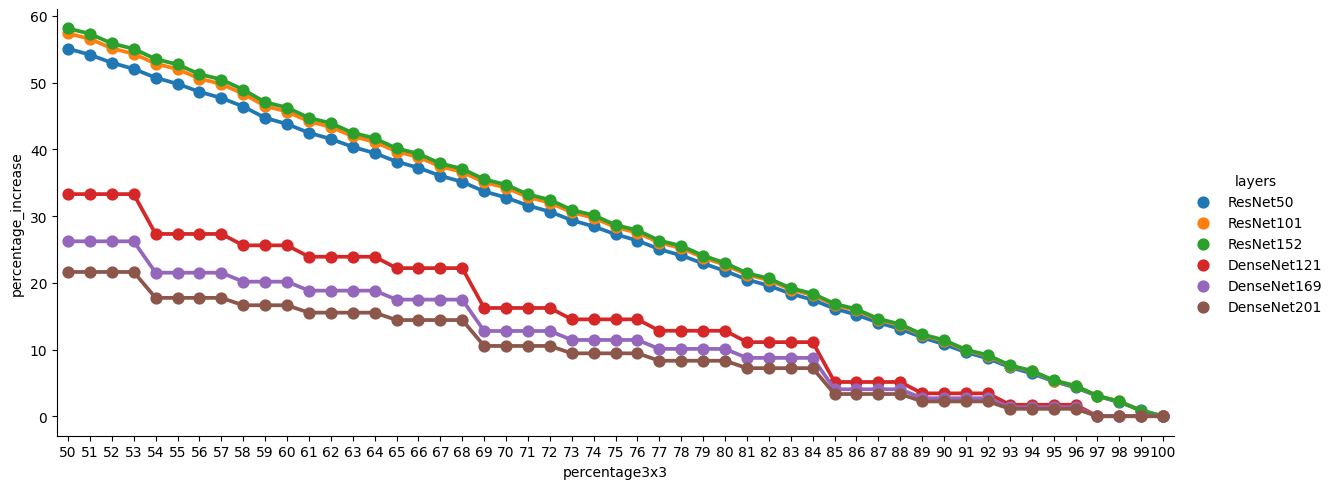

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
g = sns.catplot(x="percentage3x3", y="percentage_increase", hue='layers', data=df_res_den, kind='point',aspect=2.4)
g.figure.savefig('output_figure.png',dpi=600)

In [ ]:
! gdown 1qfB990eS6fhLoGPBHHzyyCc6cX6ciXFq

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1qfB990eS6fhLoGPBHHzyyCc6cX6ciXFq 

